# Image Processing

## 0 - Imports and utils

In [2]:
import depthai as dai
from depthai_sdk import toTensorResult
import numpy as np
import cv2
import time
import math
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
import glob
import importlib
import donkeycar.parts.lane_finding.lane_detection as ld

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.4.3 ...


In [3]:
def vis_lanes(image, lane_lines, multi_color=False):
    image_out = image
    colors = [tuple(255 * e for e in mcolors.to_rgb(c)) for n,c in mcolors.TABLEAU_COLORS.items()]
    count = 0
    for line in lane_lines:
        x1, y1, x2, y2 = line.astype(int)
        color = colors[count%len(colors)] if multi_color else (255, 0, 255)

        image_out = cv2.line(image_out.astype(np.uint8), (x1, y1), (x2, y2), color, 7)
        image_out = cv2.circle(image_out, (x1,y1), 5, (255, 0, 255), -1)
        count += 1
    return image_out

def vis_cluster_lines(image, clusters):
    image_out = image
    count = 0
    colors = [tuple(255 * e for e in mcolors.to_rgb(c)) for n,c in mcolors.TABLEAU_COLORS.items()]
    for cluster in clusters:
        color = colors[count%len(colors)]
        count += 1
        for line in cluster:
            x1, y1, x2, y2 = line.astype(int)
            image_out = cv2.line(image_out.astype(np.uint8), (x1, y1), (x2, y2), color, 7)
            image_out = cv2.circle(image_out, (x1,y1), 5, (255, 0, 255), -1)
    return image_out

def vis_points(image, points):
    image_out = image.astype(np.uint8)
    count = 1
    colors = [tuple(255 * e for e in mcolors.to_rgb(c)) for n,c in mcolors.TABLEAU_COLORS.items()]
    for line in points:
        color = colors[count%len(colors)]
        count += 1
        for point in line:
            x, y = point.astype(int)
            cv2.circle(image_out, (x,y), 5, color, -1)
    return image_out

## 1 - Pipelines

### Estimate Latency

In [326]:
BLOB_PATH = Path('road-segmentation-adas-0001_openvino_2021.4_6shave.blob')

# Create pipeline
pipeline = dai.Pipeline()

# This might improve reducing the latency on some systems
pipeline.setXLinkChunkSize(0)

# Define sources
cam = pipeline.create(dai.node.ColorCamera)

cam.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P) # 1920 x 1080
cam.setInterleaved(False)
cam.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
cam.initialControl.setManualFocus(0) # from calibration data

cam.setFps(4) # heavily influence e2e latency

cam.setPreviewKeepAspectRatio(False)
resolution = (896, 512)
cam.setPreviewSize(resolution) # wich means cropping if aspect ratio kept
cam.setIspScale(9, 19) # "scale" sensor size, (9,19) = 910x512 ; seems very slightly faster eg. from 30.48ms to 28.83ms
# see https://docs.google.com/spreadsheets/d/153yTstShkJqsPbkPOQjsVRmM8ZO3A6sCqm7uayGF-EE/edit#gid=0

# NN
nn = pipeline.create(dai.node.NeuralNetwork)
nn.setBlobPath(BLOB_PATH)

cam.preview.link(nn.input)

nn.input.setQueueSize(1)
nn.input.setBlocking(False)

# Send NN out to the host via XLink
nnXout = pipeline.create(dai.node.XLinkOut)
nnXout.setStreamName("nn")
nn.out.link(nnXout.input)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    qNn = device.getOutputQueue("nn", maxSize=1, blocking=False)

    diffs = np.array([])
    count = 0
    total_count = 20
    skip_count = 5
    last_time = dai.Clock.now()

    while count < total_count:
        nnData = qNn.get() # Blocking

        # Latency in miliseconds 
        if count >= skip_count:
            current_time = dai.Clock.now()
            latencyMs = (current_time - nnData.getTimestamp()).total_seconds() * 1000
            diffs = np.append(diffs, latencyMs)
            print('Latency: {:.2f} ms, Average latency: {:.2f} ms, Std: {:.2f}'.format(latencyMs, np.average(diffs), np.std(diffs)))
            print('Delta T: {:.2f} ms'.format((current_time - last_time).total_seconds() * 1000))
            last_time = current_time
        
        count += 1


Latency: 474.19 ms, Average latency: 474.19 ms, Std: 0.00
Delta T: 2041.29 ms
Latency: 472.77 ms, Average latency: 473.48 ms, Std: 0.71
Delta T: 248.53 ms
Latency: 472.70 ms, Average latency: 473.22 ms, Std: 0.69
Delta T: 249.90 ms
Latency: 470.98 ms, Average latency: 472.66 ms, Std: 1.14
Delta T: 248.24 ms
Latency: 473.35 ms, Average latency: 472.80 ms, Std: 1.05
Delta T: 252.34 ms
Latency: 470.17 ms, Average latency: 472.36 ms, Std: 1.37
Delta T: 246.78 ms
Latency: 470.69 ms, Average latency: 472.12 ms, Std: 1.40
Delta T: 250.49 ms
Latency: 467.57 ms, Average latency: 471.55 ms, Std: 1.99
Delta T: 250.91 ms
Latency: 465.44 ms, Average latency: 470.87 ms, Std: 2.69
Delta T: 247.83 ms
Latency: 465.99 ms, Average latency: 470.39 ms, Std: 2.94
Delta T: 250.51 ms
Latency: 467.42 ms, Average latency: 470.12 ms, Std: 2.93
Delta T: 251.39 ms
Latency: 465.63 ms, Average latency: 469.74 ms, Std: 3.07
Delta T: 248.18 ms
Latency: 466.32 ms, Average latency: 469.48 ms, Std: 3.09
Delta T: 250.65 m

### Save segmentation as png

Data shape: (4, 512, 896)
Values from 0.0 to 1.0
Segmentation image has int values from 0 to 255 with shape (512, 896, 3)
images saved


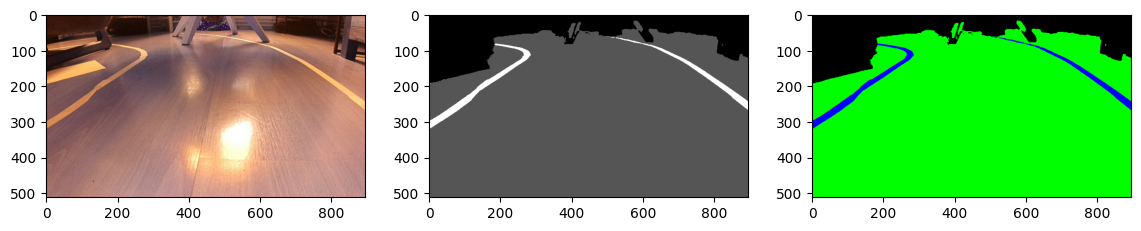

In [138]:
BLOB_PATH = Path('road-segmentation-adas-0001_openvino_2021.4_6shave.blob')

# Create pipeline
pipeline = dai.Pipeline()

# This might improve reducing the latency on some systems
pipeline.setXLinkChunkSize(0)

# Define sources
cam = pipeline.create(dai.node.ColorCamera)

cam.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P) # 1920 x 1080
cam.setInterleaved(False)
cam.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
cam.initialControl.setManualFocus(0) # from calibration data
cam.initialControl.setAutoWhiteBalanceMode(dai.CameraControl.AutoWhiteBalanceMode.FLUORESCENT) # CLOUDY_DAYLIGHT FLUORESCENT

cam.setFps(4) # heavily influence e2e latency

cam.setPreviewKeepAspectRatio(False)
resolution = (896, 512)
cam.setPreviewSize(resolution) # wich means cropping if aspect ratio kept
cam.setIspScale(9, 19) # "scale" sensor size, (9,19) = 910x512 ; seems very slightly faster eg. from 30.48ms to 28.83ms
# see https://docs.google.com/spreadsheets/d/153yTstShkJqsPbkPOQjsVRmM8ZO3A6sCqm7uayGF-EE/edit#gid=0

# NN
nn = pipeline.create(dai.node.NeuralNetwork)
nn.setBlobPath(BLOB_PATH)

cam.preview.link(nn.input)

# Send NN out to the host via XLink
nnXout = pipeline.create(dai.node.XLinkOut)
nnXout.setStreamName("nnXout")
nn.out.link(nnXout.input)

prevXout = pipeline.create(dai.node.XLinkOut)
prevXout.setStreamName("prevXout")
cam.preview.link(prevXout.input)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    qNn = device.getOutputQueue("nnXout", maxSize=2, blocking=False)
    qPrev = device.getOutputQueue("prevXout", maxSize=2, blocking=False)

    diffs = np.array([])
    count = 0
    total_count = 80
    skip_count = total_count-1
    last_time = dai.Clock.now()

    # Make sure the destination path is present before starting to store the examples
    dirName = "output"
    Path(dirName).mkdir(parents=True, exist_ok=True)

    while count < total_count:
        nnData = qNn.get() # Blocking
        prevData = qPrev.get()

        if count >= skip_count:

            # see https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html
            # and https://github.com/luxonis/depthai/blob/main/resources/nn/road-segmentation-adas-0001/handler.py
            data = np.squeeze(toTensorResult(nnData)["L0317_ReWeight_SoftMax"])
            print("Data shape: " + str(data.shape))
            print("Values from {} to {}".format(np.min(data), np.max(data)))

            # background, road, curb, mark
            classes = [0, 1, 2, 3]
            classes = np.asarray(classes, dtype=np.uint8)
            classColors = [[0, 0, 0], [0, 255, 0], [255, 0, 0], [0, 0, 255]]
            classColors = np.asarray(classColors, dtype=np.uint8)

            indices = np.argmax(data, axis=0)
            segmentation = np.take(classes, indices, axis=0)
            segmentation_colored = np.take(classColors, indices, axis=0)
            print("Segmentation image has int values from 0 to 255 with shape " + str(segmentation_colored.shape))

            frame = prevData.getCvFrame()

            now = time.time()
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_frame.png", frame)
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_data.png", data)
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_seg.png", segmentation)
            cv2.imwrite(f"{dirName}/{int(now * 1000)}_colored.png", segmentation_colored)

            print('images saved')
        
        count += 1

fig = plt.figure(figsize=(14, 8))
(rows, columns) = (1,3)

fig.add_subplot(rows, columns, 1)
plt.imshow(frame, cmap='gray', vmin=0, vmax=255)

fig.add_subplot(rows, columns, 2)
plt.imshow(segmentation, cmap='gray', vmin=0, vmax=3)

fig.add_subplot(rows, columns, 3)
plt.imshow(segmentation_colored)

plt.show()

### Take Right Camera Image

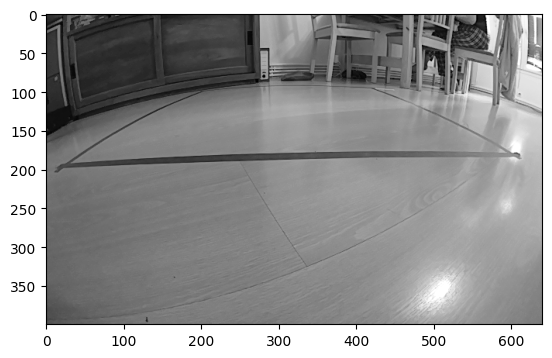

In [66]:
# Create pipeline
pipeline = dai.Pipeline()

# This might improve reducing the latency on some systems
#pipeline.setXLinkChunkSize(0)

# Define sources
cam = pipeline.create(dai.node.MonoCamera)

cam.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)
cam.setBoardSocket(dai.CameraBoardSocket.RIGHT)

cam.setFps(50) # heavily influence e2e latency

# Send NN out to the host via XLink
rightXout = pipeline.create(dai.node.XLinkOut)
rightXout.setStreamName("rightXout")
cam.out.link(rightXout.input)

# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    rightQueue = device.getOutputQueue("rightXout", maxSize=2, blocking=False)

    diffs = np.array([])
    count = 0
    warm_count = 100
    total_count = warm_count + 1
    last_time = dai.Clock.now()

    while count < total_count:
        data = rightQueue.get() # Blocking

        if count >= warm_count:
            shape = (1, data.getHeight(), data.getWidth())
            frame = data.getData().reshape(shape).transpose(1, 2, 0).astype(np.uint8)
            frame = np.ascontiguousarray(frame)

            plt.imshow(frame, cmap='gray', vmin=0, vmax=255)
            plt.show()

        count += 1

## 2 - Load Files

In [3]:
file_index = -1
files = glob.glob("output/*.png")
files.sort()
print(files)
name = '1668175723174'
frame = cv2.imread('output/' + name + '_frame.png')
segmentation = cv2.imread('output/' + name + '_seg.png')
segmentation_colored = cv2.imread('output/' + name + '_colored.png')

loaded_image = cv2.imread('output/' + name + '_colored.png')

['output/1668167835626_colored.png', 'output/1668167835626_frame.png', 'output/1668167835626_seg.png', 'output/1668167996852_colored.png', 'output/1668167996852_frame.png', 'output/1668167996852_seg.png', 'output/1668168052153_colored.png', 'output/1668168052153_frame.png', 'output/1668168052153_seg.png', 'output/1668168090341_colored.png', 'output/1668168090341_frame.png', 'output/1668168090341_seg.png', 'output/1668168131205_colored.png', 'output/1668168131205_frame.png', 'output/1668168131205_seg.png', 'output/1668175008768_colored.png', 'output/1668175008768_frame.png', 'output/1668175008768_seg.png', 'output/1668175530370_colored.png', 'output/1668175530370_frame.png', 'output/1668175530370_seg.png', 'output/1668175635224_colored.png', 'output/1668175635224_frame.png', 'output/1668175635224_seg.png', 'output/1668175676786_colored.png', 'output/1668175676786_frame.png', 'output/1668175676786_seg.png', 'output/1668175723174_colored.png', 'output/1668175723174_frame.png', 'output/166

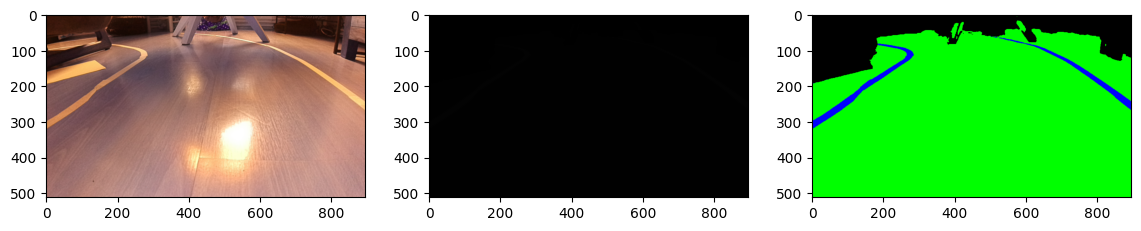

In [4]:
fig = plt.figure(figsize=(14, 8))
(rows, columns) = (1,3)

fig.add_subplot(rows, columns, 1)
plt.imshow(frame, cmap='gray', vmin=0, vmax=255)

fig.add_subplot(rows, columns, 2)
plt.imshow(segmentation, cmap='gray', vmin=0, vmax=3)

fig.add_subplot(rows, columns, 3)
plt.imshow(segmentation_colored)

plt.show()

### Segmentation from Colored Segmentation

(512, 896, 3)


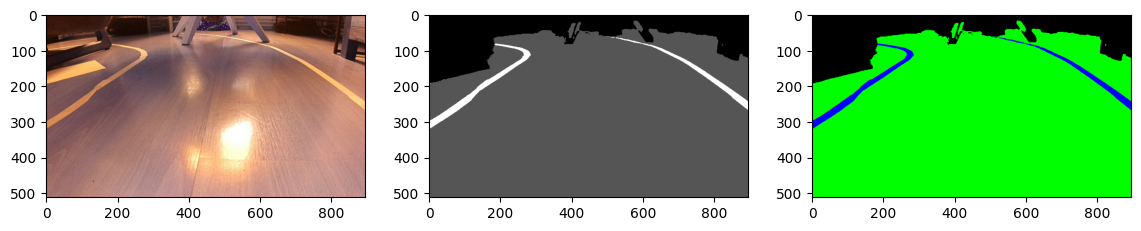

In [5]:
print(loaded_image.shape)

classes = [0, 1, 2, 3]
classes = np.asarray(classes, dtype=np.uint8)
classColors = [[0, 0, 0], [0, 255, 0], [255, 0, 0], [0, 0, 255]]
classColors = np.asarray(classColors, dtype=np.uint8)

segmentation = np.zeros((loaded_image.shape[0], loaded_image.shape[1]))
segmentation[loaded_image[:,:,1] == 255] = 1
segmentation[loaded_image[:,:,0] == 255] = 2
segmentation[loaded_image[:,:,2] == 255] = 3

# segmentation_colored = np.zeros((loaded_image.shape[0], loaded_image.shape[1], 3))
# segmentation_colored[segmentation == 1] = [0, 255, 0]
# segmentation_colored[segmentation == 2] = [255, 0, 0]
# segmentation_colored[segmentation == 3] = [0, 0, 255]

# frame = cv2.cvtColor(cv2.resize(loaded_image, (640, 400)), cv2.COLOR_RGB2GRAY)
# frame = np.stack((frame,)*3, axis=-1)

fig = plt.figure(figsize=(14, 8))
(rows, columns) = (1,3)

fig.add_subplot(rows, columns, 1)
plt.imshow(frame)

fig.add_subplot(rows, columns, 2)
plt.imshow(segmentation, cmap='gray', vmin=0, vmax=3)

fig.add_subplot(rows, columns, 3)
plt.imshow(segmentation_colored)

plt.show()

## 3 - Rectify Perspective

In [6]:
from donkeycar.parts.lane_finding.perspective import Birdeye
birdeye = Birdeye(*frame.shape[:2], vanishing_point=-0.063, crop_top=0.098, crop_corner=1, height_ratio=600/512)
rectified_segmentation = birdeye.apply(segmentation)

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.4.3 ...


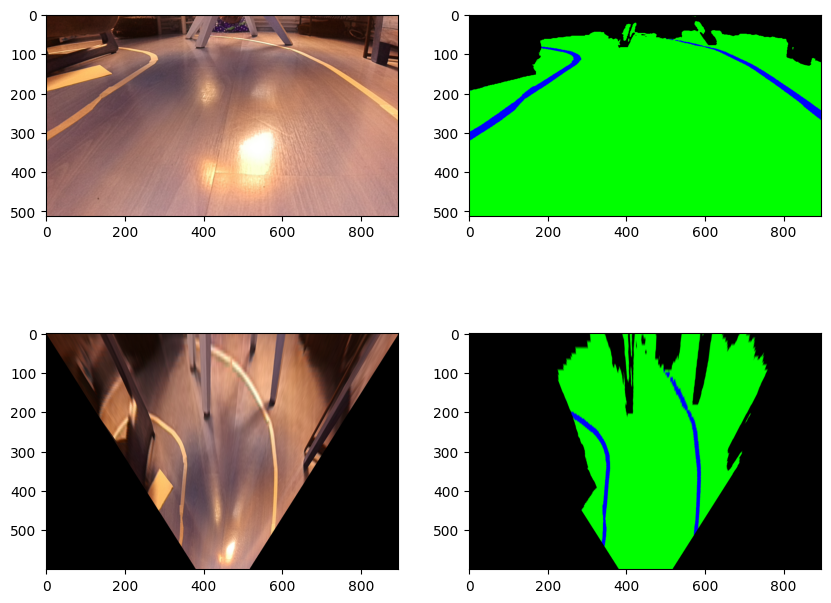

In [7]:
rectified_segmentation = birdeye.apply(segmentation)
rectified_segmentation_colored = birdeye.apply(segmentation_colored)
rectified_frame = birdeye.apply(frame)

dirName = "output"
cv2.imwrite(f"{dirName}/rectified_frame.png", rectified_frame)

fig = plt.figure(figsize=(10, 8))
(rows, columns) = (2,2)

# image = np.reshape(frame, (400, 640))
# image = np.stack((image,)*3, axis=-1)
image = frame
fig.add_subplot(rows, columns, 1)
plt.imshow(image)

fig.add_subplot(rows, columns, 2)
plt.imshow(segmentation_colored)

#image = np.stack((rectified_frame,)*3, axis=-1)
image = rectified_frame
ax = fig.add_subplot(rows, columns, 3)
plt.imshow(image)

ax = fig.add_subplot(rows, columns, 4)
plt.imshow(rectified_segmentation_colored)

plt.show()

## 4 - Hough transform: Estimate Lane Lines

lines count: 19
merged lines count: 10


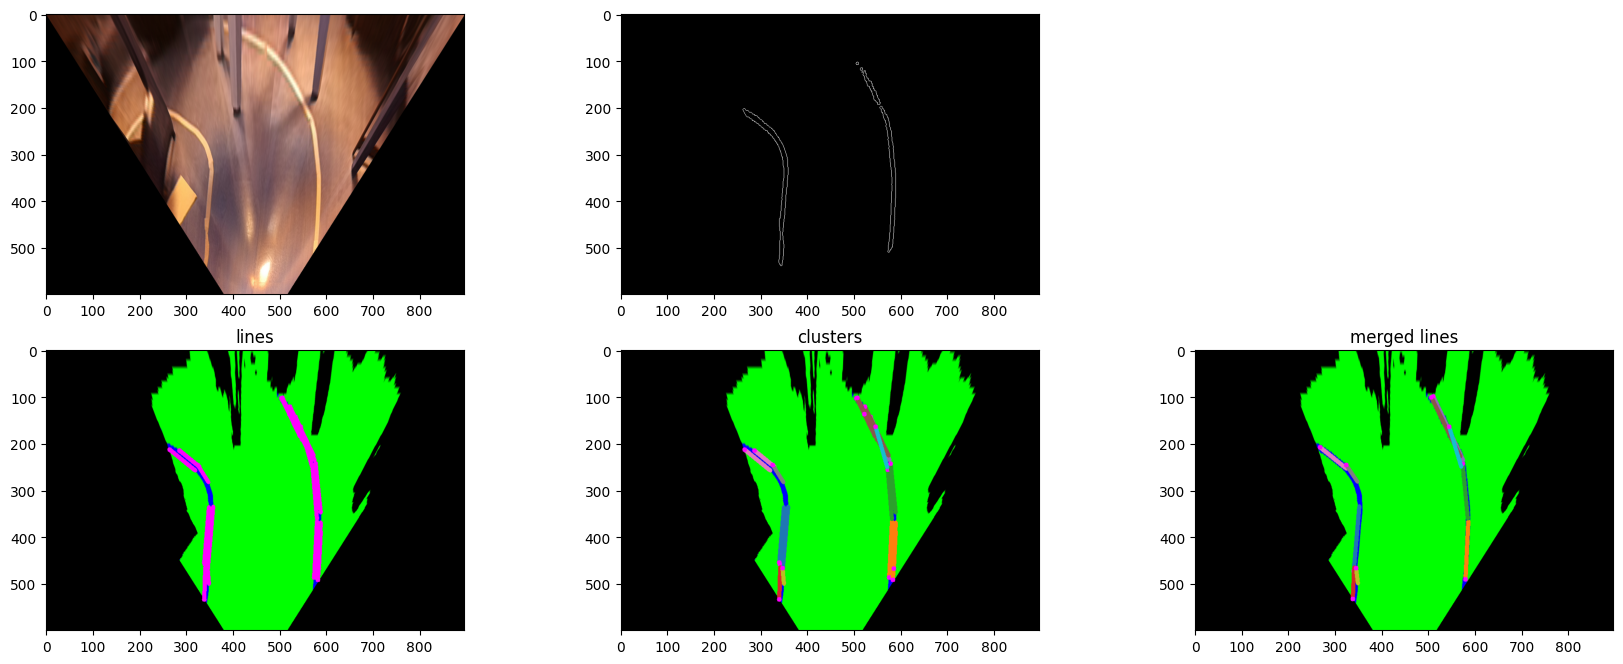

In [18]:
importlib.reload(ld)
if 1:
    src_frame = rectified_frame
    src_segmentation = rectified_segmentation
    src_segmentation_colored = rectified_segmentation_colored
else:
    src_frame = frame
    src_segmentation = segmentation
    src_segmentation_colored = segmentation_colored

binary = ld.binarize_segmentation(src_segmentation)
lines, edges = ld.detect_hough_lines(binary, hough_threshold=30, hough_min_line_length=30, hough_max_line_gap=20)
merged_lines, clusters = ld.merge_lane_lines(lines, slope_similarity_threshold=0.1, intercept_similarity_threshold=20)

print('lines count: ' + str(lines.shape[0]))
print('merged lines count: ' + str(merged_lines.shape[0]))

# image = np.reshape(src_frame, (400, 640))
# image = np.stack((image,)*3, axis=-1)

fig = plt.figure(figsize=(21, 8))
(rows, columns) = (2,3)

fig.add_subplot(rows, columns, 1)
plt.imshow(src_frame)

fig.add_subplot(rows, columns, 2)
plt.imshow(edges, cmap='gray', vmin=0, vmax=255)

ax = fig.add_subplot(rows, columns, 4)
plt.imshow(vis_lanes(src_segmentation_colored, lines))
ax.set_title("lines")

ax = fig.add_subplot(rows, columns, 5)
plt.imshow(vis_cluster_lines(src_segmentation_colored, clusters))
ax.set_title("clusters")

ax = fig.add_subplot(rows, columns, 6)
plt.imshow(vis_lanes(src_segmentation_colored, merged_lines, multi_color=True))
ax.set_title("merged lines")

plt.show()

## 5 - Discretize Lane Lines

In [59]:
from queue import SimpleQueue
importlib.reload(ld)

def calc_point_to_segment_distance(p1, p2, p):
    # http://paulbourke.net/geometry/pointlineplane/
    u = (p[0] - p1[0]) * (p2[0] - p1[0]) + (p[1] - p1[1]) * (p2[1] - p1[1]) / np.linalg.norm(p2 - p1) ** 2
    u = min(1.0, max(0.0, u))
    d = np.linalg.norm(p1 + u * (p2 - p1) - p)
    return d

def calc_lines_distances(lines):
    distances = np.ones((lines.shape[0], lines.shape[0])) * np.inf
    for i, iline in enumerate(lines):
        for j, jline in enumerate(lines):
            if i != j:
                d1 = calc_point_to_segment_distance(jline[:2], jline[2:], iline[:2])
                d2 = calc_point_to_segment_distance(jline[:2], jline[2:], iline[2:])
                d = min(d1, d2)
    #             if i < j:
    #                 distances[i, j] =  min(d1, d2)
    #             else:
    #                 distances[i, j] = distances[j, i] = min(d1, d2, distances[j, i])
    # return distances
                k = min(i, j)
                l = max(i, j)
                distances[k, l] = min(d, distances[k, l])
    # diag symetry for easier search
    return np.min(np.dstack((distances, distances.T)), axis=2)


def associate_lines_2(lines, origin, threshold=50):
    distances = calc_lines_distances(lines)

    todo = [i for i in range(lines.shape[0])]
    lanes = []
    open = SimpleQueue()
    while len(todo) > 0:
        i, _, _, _ = ld._find_nearest_from_point(lines[todo], origin)
        print('---')
        open.put(todo[i])
        current_lane_idx = []
        while not open.empty():
            idx = open.get()
            if idx in todo:
                print(idx)
                todo.remove(idx)
                current_lane_idx.append(idx)
                next_idx = np.argwhere(distances[idx, :] <= threshold)
                for i in next_idx.flatten().tolist():
                    open.put(i)
        lanes.append(lines[current_lane_idx])
        
    return [np.array(lane) for lane in lanes]

[[339.66352068 473.5557295  351.2384407  334.52034091]
 [578.52732428 491.87770109 584.73921434 366.2838624 ]
 [572.10996407 243.36490087 583.20143971 361.60588822]
 [337.99950042 533.99998551 340.00049958 465.00001449]
 [509.64893774  99.83543826 573.21731208 236.36442224]
 [505.52614851 101.74363023 567.20856785 228.33466088]
 [267.69631899 208.47047903 324.23733729 254.61081949]
 [323.99963937 246.00022419 347.00036063 282.99977581]
 [344.99950387 467.00004379 348.00049613 500.99995621]
 [543.99953814 164.00013272 569.00046186 250.99986728]]
---
3
0
8
7
6
---
1
2
4
5
9
origin: [448 600]
clusters: 10
found 2 lanes


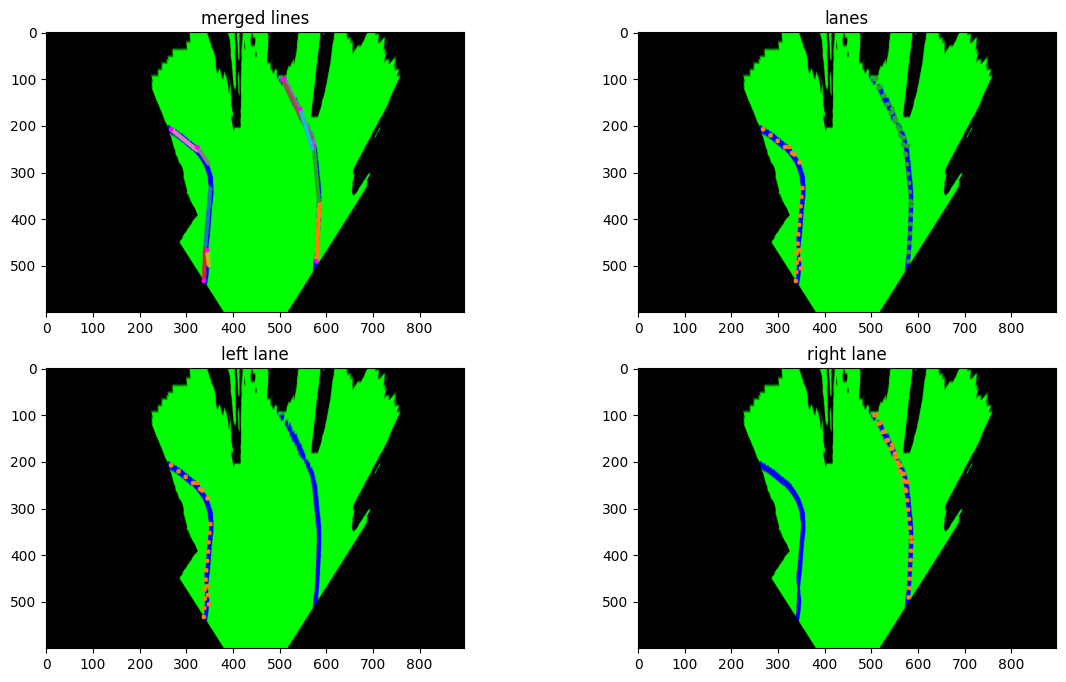

In [60]:
origin = np.array([int(src_segmentation.shape[1] / 2), src_segmentation.shape[0]])
print(merged_lines)
lane_lines = associate_lines_2(merged_lines, origin, threshold=70)
lanes_points = ld.discretize_lanes_2(lane_lines)
left_lane, right_lane = ld.find_left_right_lanes(lanes_points, origin)

print("origin: " + str(origin))
print('clusters: ' + str(len(merged_lines)))
print('found ' + str(len(lane_lines)) + ' lanes')

fig = plt.figure(figsize=(14, 8))
(rows, columns) = (2,2)

ax = fig.add_subplot(rows, columns, 1)
plt.imshow(vis_lanes(src_segmentation_colored, merged_lines, multi_color=True))
ax.set_title("merged lines")

ax = fig.add_subplot(rows, columns, 2)
plt.imshow(vis_points(src_segmentation_colored, lanes_points))
ax.set_title("lanes")

ax = fig.add_subplot(rows, columns, 3)
plt.imshow(vis_points(src_segmentation_colored, [left_lane]))
ax.set_title("left lane")

ax = fig.add_subplot(rows, columns, 4)
plt.imshow(vis_points(src_segmentation_colored, [right_lane]))
ax.set_title("right lane")

plt.show()

## 6 - Estimate Path

In [61]:
from donkeycar.parts.lane_detection import estimate_path

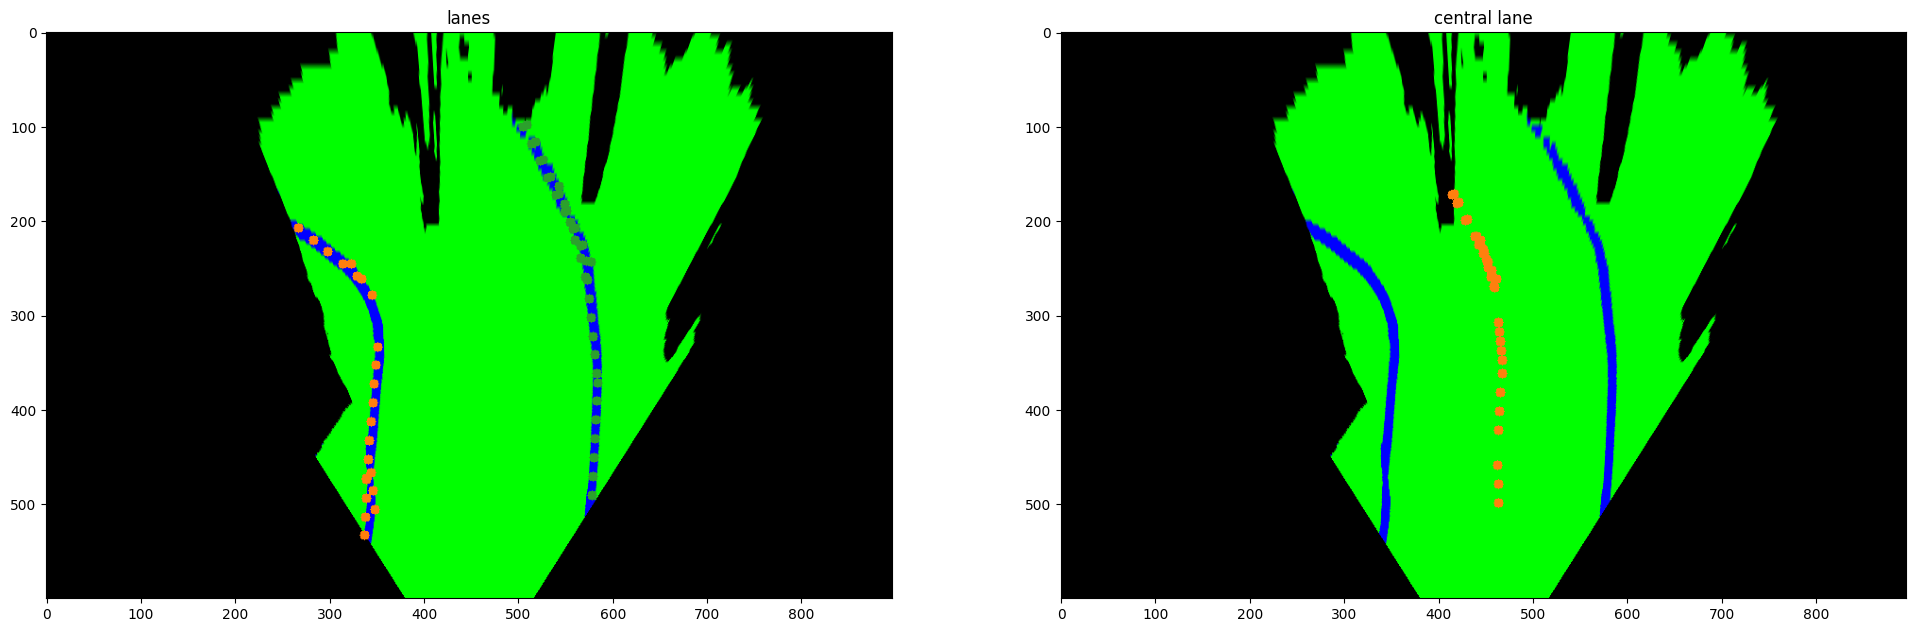

In [62]:
central_lane = estimate_path(left_lane, right_lane)

fig = plt.figure(figsize=(24, 8))
(rows, columns) = (1,2)

ax = fig.add_subplot(rows, columns, 1)
plt.imshow(vis_points(src_segmentation_colored, lanes_points))
ax.set_title("lanes")

ax = fig.add_subplot(rows, columns, 2)
plt.imshow(vis_points(src_segmentation_colored, [central_lane]))
ax.set_title("central lane")

plt.show()

In [63]:
from donkeycar.parts.lane_detection import regularize_lane

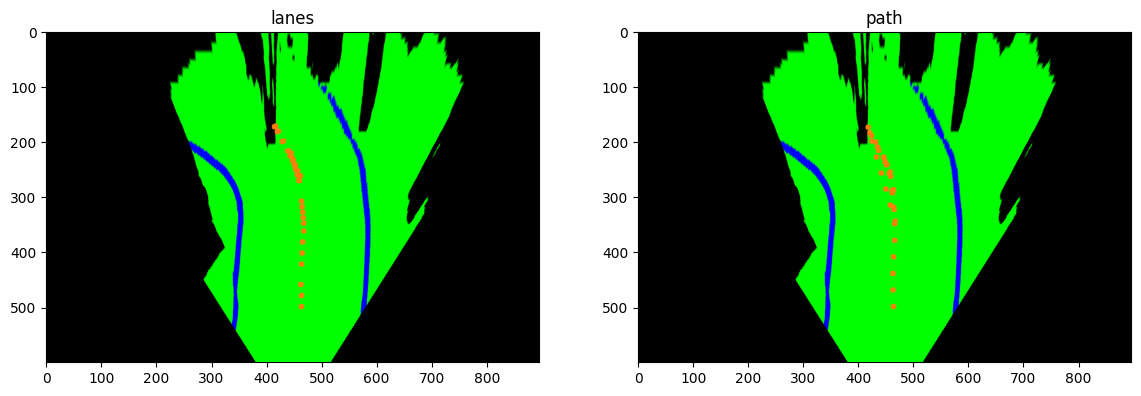

In [64]:
path = regularize_lane(central_lane)

fig = plt.figure(figsize=(14, 8))
(rows, columns) = (1,2)

ax = fig.add_subplot(rows, columns, 1)
plt.imshow(vis_points(src_segmentation_colored, [central_lane]))
ax.set_title("lanes")

ax = fig.add_subplot(rows, columns, 2)
plt.imshow(vis_points(src_segmentation_colored, [path]))
ax.set_title("path")

plt.show()

## 7 - To Vehicule Frame

In [17]:
from donkeycar.parts.lane_detection import path_to_vehicule_frame

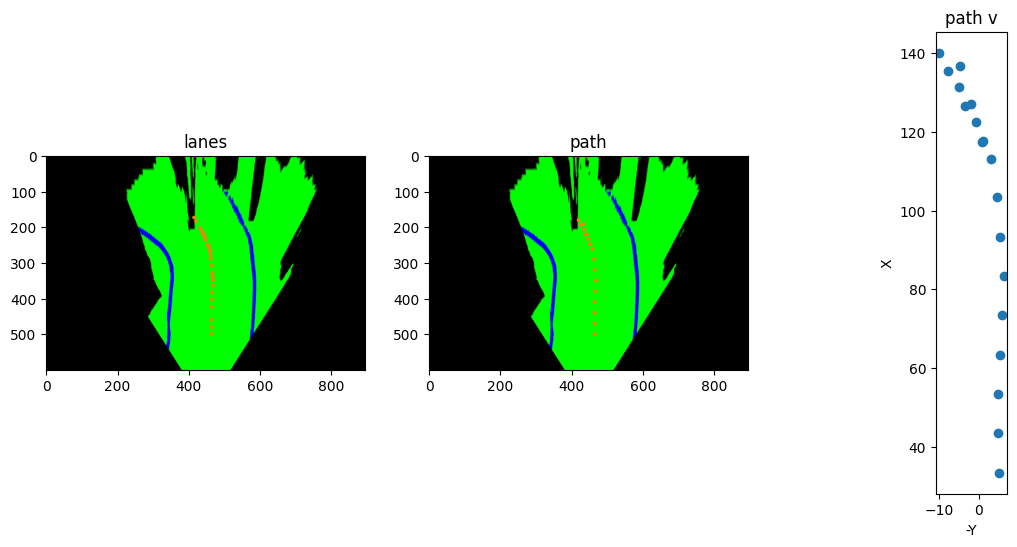

array([103.08343169,   9.97733385])

In [18]:
path_v = path_to_vehicule_frame(path, origin, pixel_in_cm=0.333)

fig = plt.figure(figsize=(14, 6))
(rows, columns) = (1,3)

ax = fig.add_subplot(rows, columns, 1)
plt.imshow(vis_points(src_segmentation_colored, [central_lane]))
ax.set_title("lanes")

ax = fig.add_subplot(rows, columns, 2)
plt.imshow(vis_points(src_segmentation_colored, [path]))
ax.set_title("path")

ax = fig.add_subplot(rows, columns, 3)
ax.scatter(-path_v[:,1], path_v[:,0])
ax.set_title("path v")
ax.set_xlabel("-Y")
ax.set_ylabel("X")
ax.set_aspect('equal', adjustable='box')

plt.show()

path_v[-1] - path_v[0]


## 8 - End to End

In [8]:
from donkeycar.parts.lane_finding.perspective import Birdeye
from donkeycar.parts.lane_detection import estimate_lane_lines, merge_lane_lines
from donkeycar.parts.lane_detection import associate_lines, discretize_lanes, find_left_right_lanes
from donkeycar.parts.lane_detection import associate_lines, discretize_lanes, find_left_right_lanes
from donkeycar.parts.lane_detection import estimate_path
from donkeycar.parts.lane_detection import regularize_lane
from donkeycar.parts.lane_detection import path_to_vehicule_frame

In [9]:
birdeye = Birdeye(*frame.shape[:2], vanishing_point=-0.063, crop_top=0.098, crop_corner=1, height_ratio=600/512)
rectified_segmentation = birdeye.apply(segmentation)
rectified_segmentation_colored = birdeye.apply(segmentation_colored)
rectified_frame = birdeye.apply(frame)

reference = cv2.imread("output/1668168131205_frame.png")
reference = birdeye.apply(reference)

lines, edges = estimate_lane_lines(rectified_segmentation, hough_threshold=30, hough_min_line_length=30, hough_max_line_gap=20)
merged_lines, lines_clusters = merge_lane_lines(lines, slope_similarity_threshold=0.1, intercept_similarity_threshold=20)

origin = np.array([int(rectified_segmentation.shape[1] / 2), rectified_segmentation.shape[0]])

lane_lines = associate_lines(merged_lines, origin, threshold=70)
lanes = discretize_lanes(lane_lines)
left_lane, right_lane = find_left_right_lanes(lanes, origin)
estimated_path = estimate_path(left_lane, right_lane)
path = regularize_lane(estimated_path)
path_v = path_to_vehicule_frame(path, origin, pixel_in_cm=0.333)

merged lines count: 10


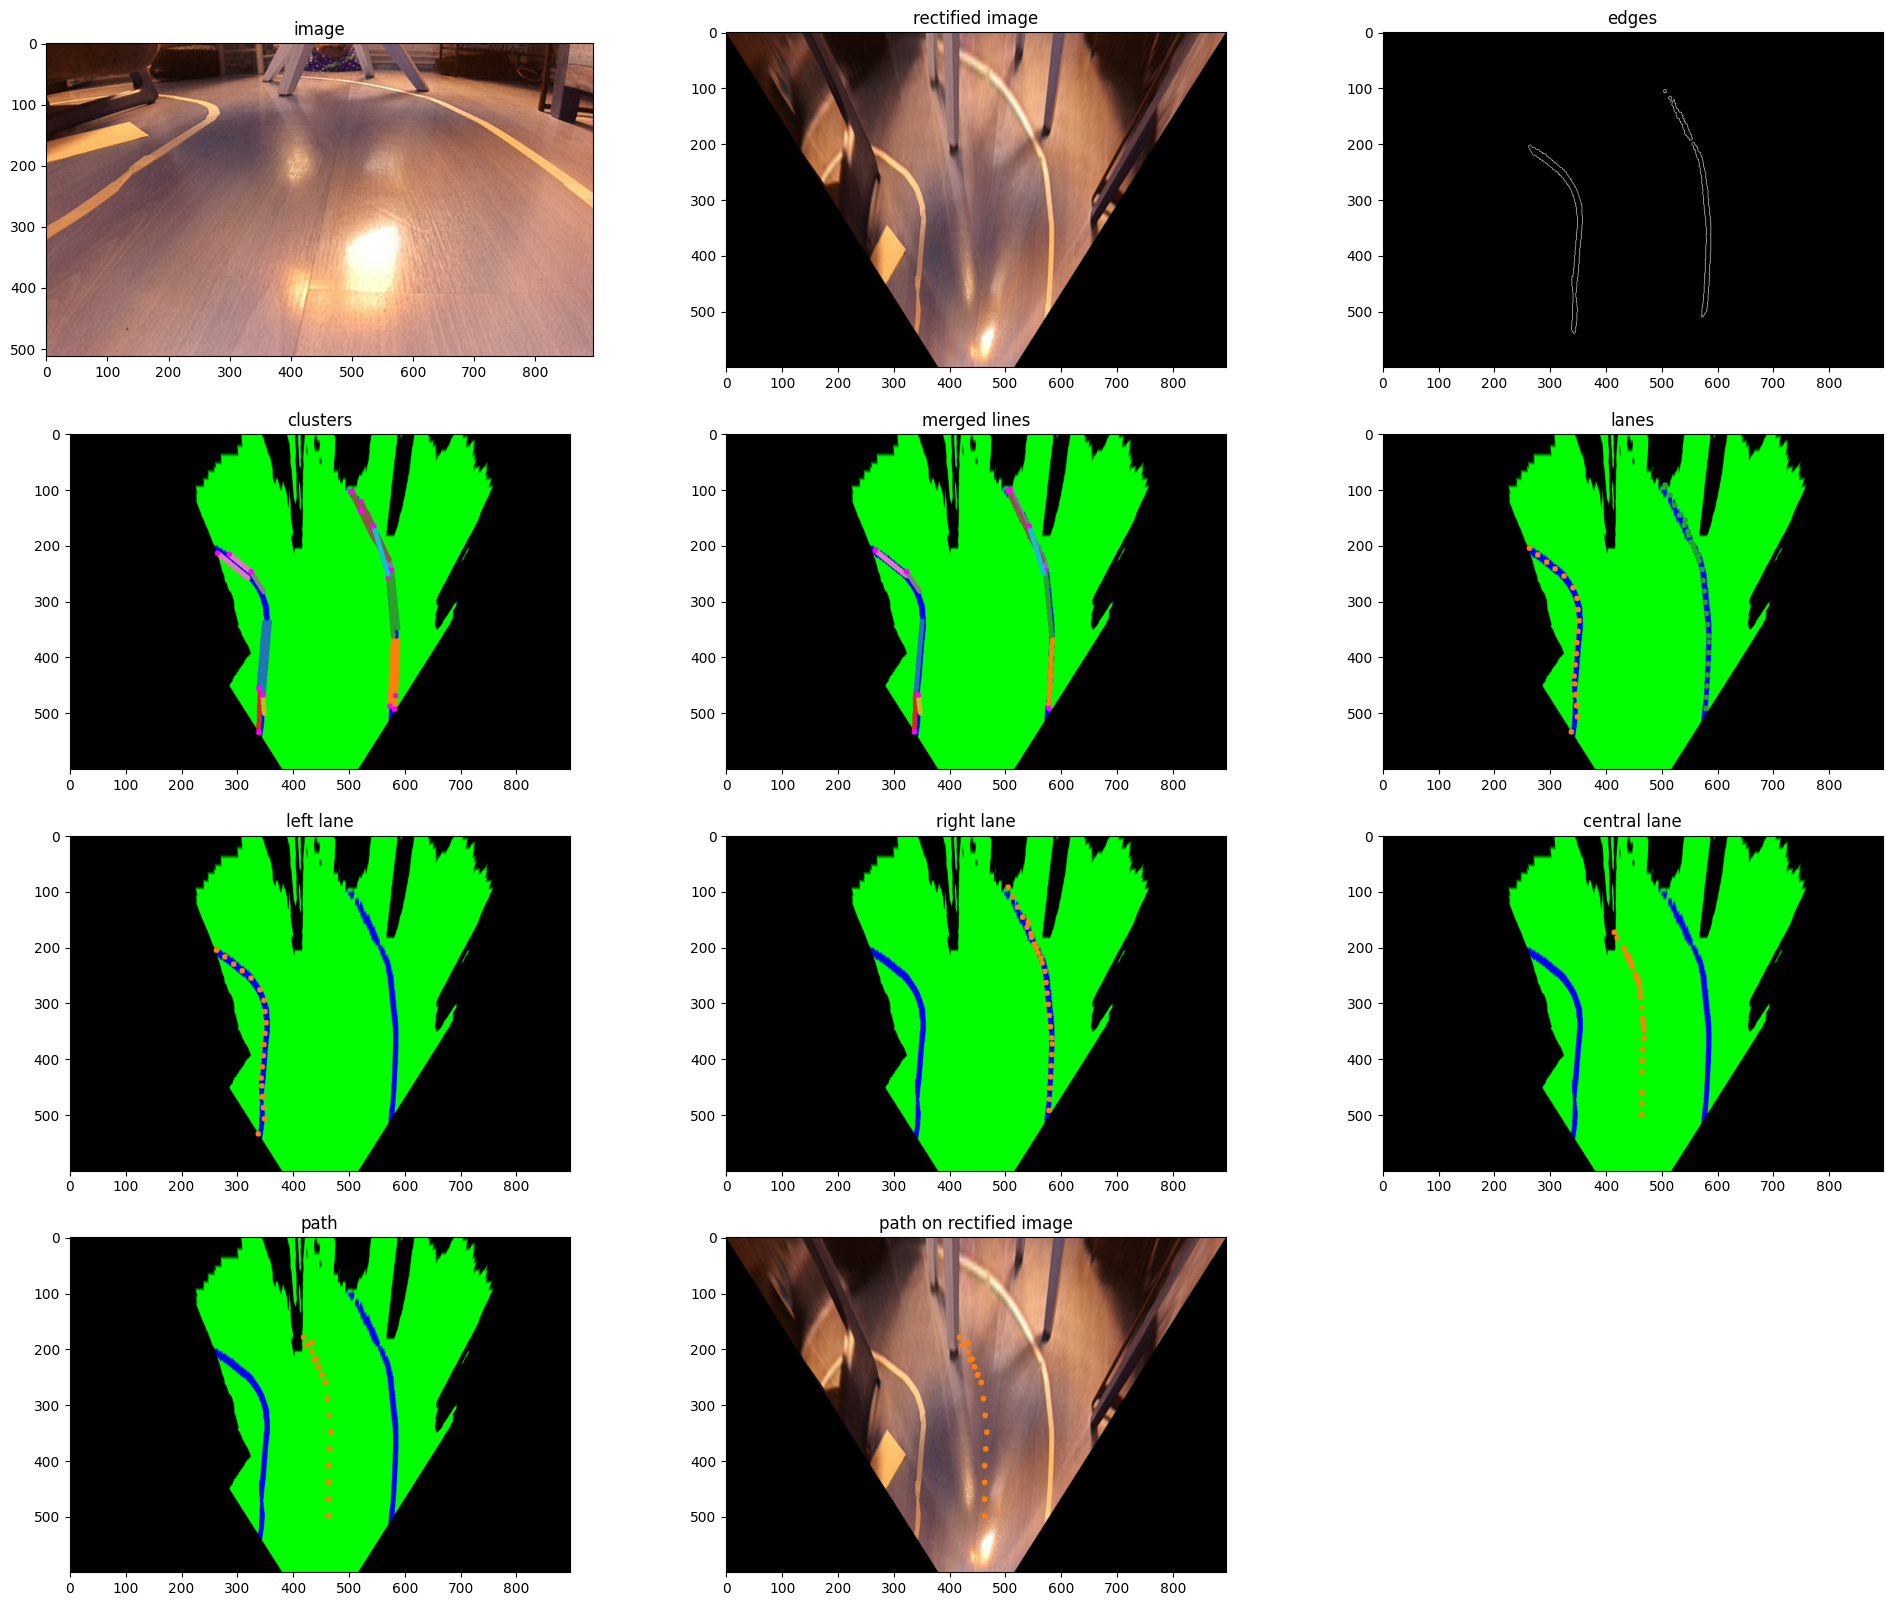

In [10]:
fig = plt.figure(figsize=(24, 20))
(rows, columns) = (4,3)

ax = fig.add_subplot(rows, columns, 1)
plt.imshow(frame)
ax.set_title("image")

ax = fig.add_subplot(rows, columns, 2)
plt.imshow(rectified_frame)
ax.set_title("rectified image")

ax = fig.add_subplot(rows, columns, 3)
plt.imshow(edges, cmap='gray', vmin=0, vmax=255)
ax.set_title("edges")

ax = fig.add_subplot(rows, columns, 4)
plt.imshow(vis_cluster_lines(rectified_segmentation_colored, lines_clusters))
ax.set_title("clusters")
print('merged lines count: ' + str(merged_lines.shape[0]))

ax = fig.add_subplot(rows, columns, 5)
plt.imshow(vis_lanes(rectified_segmentation_colored, merged_lines, multi_color=True))
ax.set_title("merged lines")

ax = fig.add_subplot(rows, columns, 6)
plt.imshow(vis_points(rectified_segmentation_colored, lanes))
ax.set_title("lanes")

ax = fig.add_subplot(rows, columns, 7)
plt.imshow(vis_points(rectified_segmentation_colored, [left_lane]))
ax.set_title("left lane")

ax = fig.add_subplot(rows, columns, 8)
plt.imshow(vis_points(rectified_segmentation_colored, [right_lane]))
ax.set_title("right lane")

ax = fig.add_subplot(rows, columns, 9)
plt.imshow(vis_points(rectified_segmentation_colored, [estimated_path]))
ax.set_title("central lane")

ax = fig.add_subplot(rows, columns, 10)
plt.imshow(vis_points(rectified_segmentation_colored, [path]))
ax.set_title("path")

ax = fig.add_subplot(rows, columns, 11)
plt.imshow(vis_points(rectified_frame, [path]))
ax.set_title("path on rectified image")

plt.show()

## 9 - WIP

In [274]:
import donkeycar.parts.lane_finding.lane_detection2 as ld

In [275]:
importlib.reload(ld)

files = glob.glob("../donkeycar/parts/lane_finding/test_images/*.jpg")
files.sort()
#print(files)
number = '161' #'294b'
image_name = '../donkeycar/parts/lane_finding/test_images/' + number + '_cam_image_array_.jpg'
ld.main(image_name)


../donkeycar/parts/lane_finding/test_images/161_cam_image_array_.jpg
--- 0
--- 1
--- 2
--- 3
WARNING found points that where not assigned to left or right lane


NameError: name 'plt' is not defined